In [1]:
! pip install patchify

In [2]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
!ls -lah '/content/drive/MyDrive/Semantic segmentation dataset'

total 33K
-rw------- 1 root root  548 Sep 22 09:54  classes.json
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 1'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 2'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 3'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 4'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 5'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 6'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 7'
drwx------ 4 root root 4.0K Sep 22 09:56 'Tile 8'


In [4]:
dataset_root_folder = r'C:\Datasets'

In [5]:
dataset_name = r"Semantic segmentation dataset"

In [6]:
for path, subdirs, files in os.walk(dataset_root_folder, dataset_name):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)

  if dir_name == 'images':
    images = os.listdir(path)
    #print(images)

    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')):
        #print(image_name)
        a = True

In [7]:
image_patch_size = 256

In [8]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)




In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [10]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


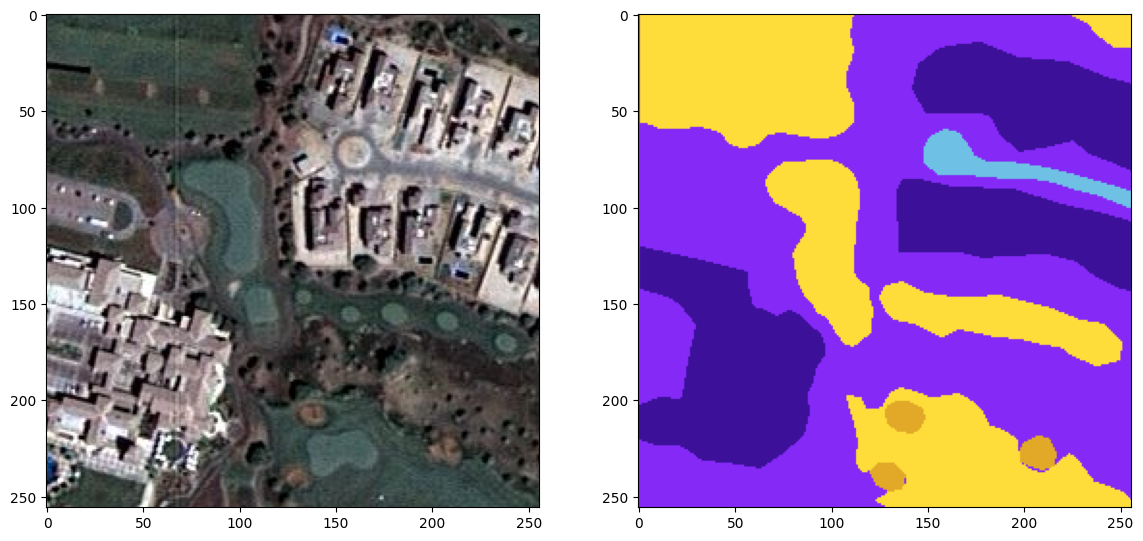

In [11]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [12]:

class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [13]:
label = individual_patched_mask

In [14]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [16]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [17]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [18]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


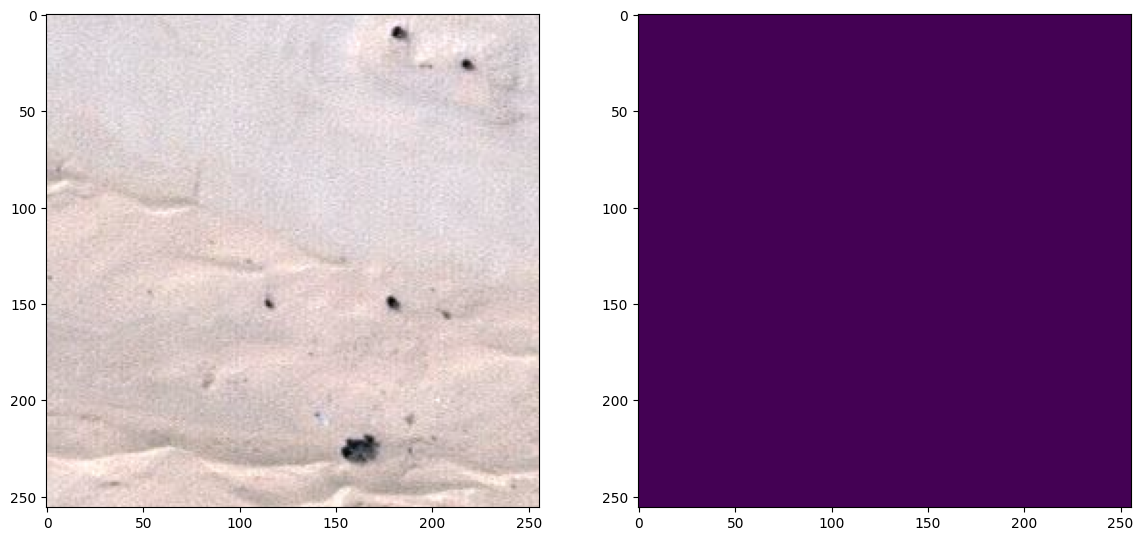

In [19]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
#plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [20]:
total_classes = len(np.unique(labels))

In [21]:
total_classes

6

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [24]:
master_trianing_dataset = image_dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [28]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [29]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [30]:
! pip install -U segmentation-models

     ---------------------------------------- 0.0/50.7 kB ? eta -:--:--
     ---------------------------------------- 50.7/50.7 kB ? eta 0:00:00
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/32/b2/1811645651153407f1e715b75afe9962d87582bee70b42c8671c255f8fe6/scikit_image-0.21.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/eb/21/662994d78d8623055f8ffa91838e28f04b2a34bd5d8d6dbc6c7573285ed6/imageio-2.31.3-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/36/06/b5408ce5edf09a3ee0ee531dadb2afc85ffb7624515b223b226b4a45a1d2/tifffile-2023.9.18-py3-none-any.whl.metadata
  Obtaining dependency information for lazy_loader>=0.2 from https://files.pythonhosted.org/packages/a1/c3/65b3814e155836acacf720e5be3b5757130346670ac454fee29d3eda1381/lazy_loader-0.3-py3-none-any.whl.metadata
   ---

In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [32]:
from keras import backend as K

In [33]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [34]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [35]:
metrics = ["accuracy", jaccard_coef]

In [36]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [37]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [38]:
model = get_deep_learning_model()

In [40]:
#model.get_config()

In [39]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [40]:
! pip install -U -q segmentation-models
! pip install -q tensorflow==2.2.1
! pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.14.0rc0, 2.14.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.

Segmentation Models: using `tf.keras` framework.


In [41]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [42]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [43]:
total_loss = dice_loss + (1 * focal_loss)

In [44]:
import tensorflow as tf

In [45]:
tf.keras.backend.clear_session()

In [46]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [48]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/100
51/51 [==============================] - 321s 6s/step - loss: 0.9982 - accuracy: 0.5604 - jaccard_coef: 0.2766 - val_loss: 0.9921 - val_accuracy: 0.6084 - val_jaccard_coef: 0.3085
Epoch 2/100
51/51 [==============================] - 265s 5s/step - loss: 0.9811 - accuracy: 0.6646 - jaccard_coef: 0.3724 - val_loss: 0.9716 - val_accuracy: 0.6941 - val_jaccard_coef: 0.4056
Epoch 3/100
27/51 [==============>...............] - ETA: 2:07 - loss: 0.9659 - accuracy: 0.7126 - jaccard_coef: 0.4490

In [ ]:
history_a = model_history

In [ ]:
history_a.history

In [ ]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [ ]:
y_pred_argmax

In [ ]:
y_test_argmax = np.argmax(y_test, axis=3)

In [ ]:
y_test_argmax

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [ ]:
model.save("satellite_segmentation_full.h5")